In [1]:
from glob import iglob
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (12,7)
pylab.rcParams['font.size'] = 12
pylab.rcParams['legend.fontsize'] = 12

In [3]:
import itertools

# From http://eleanormaclure.files.wordpress.com/2011/03/colour-coding.pdf
colors = (
#    '#FFFFFF',  # White
#    '#000000',  # Black
    '#FFB300',  # Vivid Yellow
    '#803E75',  # Strong Purple
    '#FF6800',  # Vivid Orange
    '#A6BDD7',  # Very Light Blue
    '#C10020',  # Vivid Red
    '#CEA262',  # Grayish Yellow
#    '#817066',  # Medium Gray
    '#007D34',  # Vivid Green
    '#F6768E',  # Strong Purplish Pink
    '#00538A',  # Strong Blue
    '#FF7A5C',  # Strong Yellowish Pink
    '#53377A',  # Strong Violet
    '#FF8E00',  # Vivid Orange Yellow
    '#B32851',  # Strong Purplish Red
#    '#F4C800',  # Vivid Greenish Yellow
    '#7F180D',  # Strong Reddish Brown
    '#93AA00',  # Vivid Yellowish Green
    '#593315',  # Deep Yellowish Brown
    '#F13A13',  # Vivid Reddish Orange
    '#232C16',  # Dark Olive Green
)


def color(i):
    return colors[i % len(colors)]


def color_cycle():
    return itertools.cycle(colors)

markers = "sov^Dp<>*h8x+"


def marker(i):
    return markers[i % len(markers)]


def marker_cycle():
    return itertools.cycle(markers)


def unique_index(value, series):
    return list(series.unique()).index(value)

In [4]:
def ideal(x=1, y=None, steps=100, ls=':', color='black', linewidth=.5, **kwargs):
    l_x = np.linspace(0, x, steps)
    if y is None:
        l_y = l_x
    else:
        l_y = np.linspace(0, y, steps)
    plt.plot(l_x, l_y, ls=ls, color=color, linewidth=linewidth)

In [5]:
def read_daq_summary(filename):
    with open(filename) as file:
        data = []
        for line in file:
            m = re.match(r'Total (?:VDD )?Energy: ([0-9.]+)J Average (?:VDD )?Power: ([0-9.]+)W', line)
            if m:
                data.append({'daq_energy': float(m.group(1)), 'daq_power': float(m.group(2))})
        #print("Read {} rows for {}".format(len(data), filename))
        return data
                
def read_rapl_summary(filename):
    with open(filename) as file:
        data = []
        for line in file:
            m = re.match(r'Trace \d+ ([0-9.]+)J, ([0-9.]+) seconds, ([0-9.]+)W', line)
            if m:
                data.append({'rapl_energy': float(m.group(1)), 'rapl_power': float(m.group(3))})
        #print("Read {} rows for {}".format(len(data), filename))
        return data

In [6]:
df = pd.DataFrame()
for root, _, filenames in os.walk('.'):
    if 'rapl_summary' in filenames and 'daq_summary' in filenames:
        rapl = read_rapl_summary(os.path.join(root, 'rapl_summary'))
        daq = read_daq_summary(os.path.join(root, 'daq_summary'))
    elif 'rapl_results' in filenames and 'daq_results' in filenames:
        rapl = read_rapl_summary(os.path.join(root, 'rapl_results'))
        daq = read_daq_summary(os.path.join(root, 'daq_results'))
    else:
        continue
    split = root.split(os.sep)
    if 'old' in split:
        continue
    meta = {'generation': split[1], 'system': split[2], 'memory': split[3], 'workload': split[4]}
    try:
        meta['rate'] = split[5]
    except IndexError:
        pass
    df = df.append(pd.DataFrame([{**r, **d, **meta} for r, d in zip(rapl, daq)]))

ddr3 haswell-i5


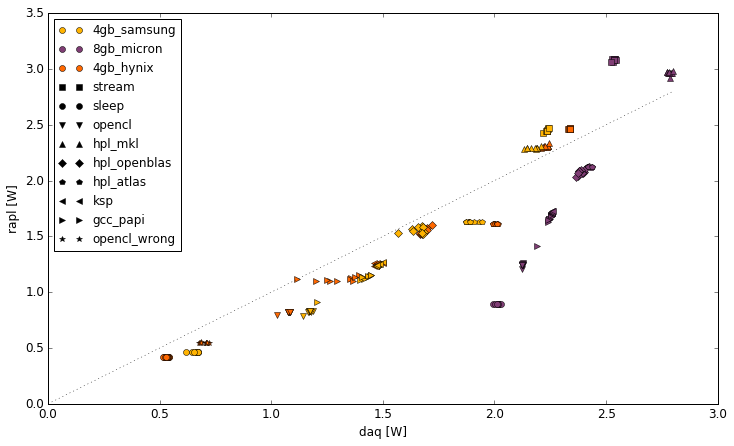

ddr3 haswell-i7


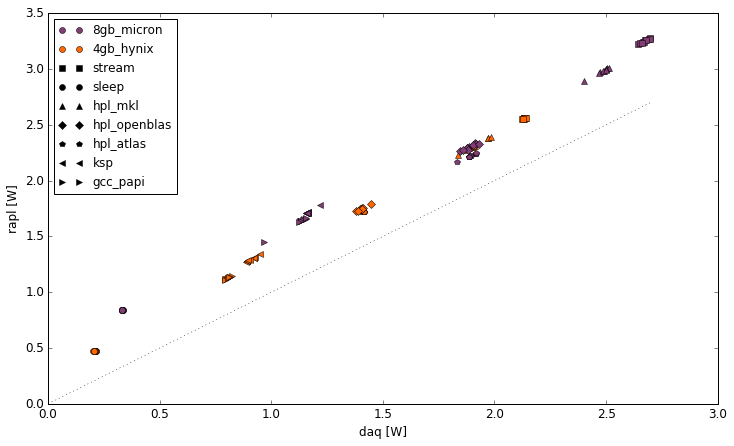

ddr4 haswell-ep


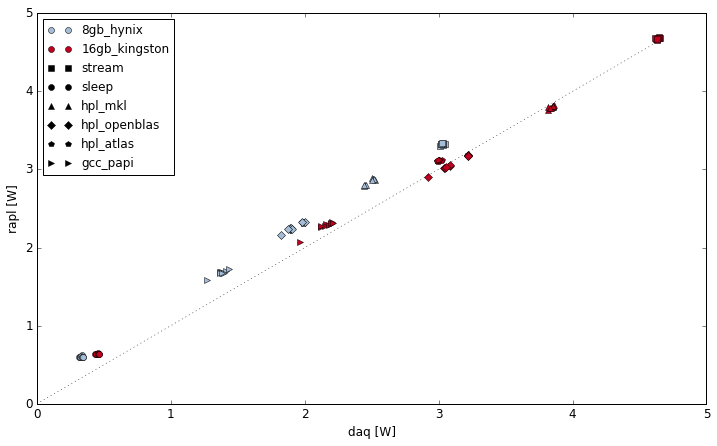

In [7]:
for (generation, system), grp in df.groupby(['generation', 'system']):
    print(generation, system)
    mark = marker_cycle()
    col = color_cycle()
    for (memory, workload), grp2 in grp.groupby(['memory', 'workload']):
        plt.plot(grp2['daq_power'], grp2['rapl_power'], label='', ls='',
                 marker=marker(unique_index(workload, df.workload)),
                 color=color(unique_index(memory, df.memory)))

    for memory in grp.memory.unique():
        plt.plot([], [], marker='o', color=color(unique_index(memory, df.memory)), label=memory, ls='')
    for workload in grp.workload.unique():
        plt.plot([], [], marker=marker(unique_index(workload, df.workload)), color='black', label=workload, ls='')

    plt.xlabel('daq [W]')
    plt.ylabel('rapl [W]')
    plt.legend(loc='best')
    ideal(min(grp.daq_power.max(), grp.rapl_power.max()))
    plt.show()
    